In [4]:
import datetime

current_time = datetime.datetime.now()

formatted_time = current_time.strftime("%Y-%m-%d %H:%M:%S")

last_run_note = f"Notebook last ran on: {formatted_time}"

print(last_run_note)


Notebook last ran on: 2024-04-13 16:03:06


# Price prediction model based on latitude and longitude data 🌎


1. **Data Preparation** 📊:
   - Start with a dataset comprising 1547 entries of electric charging stations across India.
   - Features include the name, state, city, address, latitude, longitude, and type of each station.

2. **Data Cleaning** 🧹:
   - First, remove entries with missing latitude and longitude values to ensure accuracy.
   - Then, convert latitude and longitude values to float data type for consistency and ease of analysis.

3. **Exploratory Data Analysis (EDA)** 🧭:
   - Visualize the geographical distribution of charging stations by plotting their coordinates on a map.
   - Create a heatmap using Folium to visualize the density of charging stations across different regions.
   - Analyze the distribution of stations by city and state to identify hotspots and patterns.

4. **Geospatial Analysis** 🗺️:
   - Employ Basemap, GeoPandas, and Shapely libraries to transform latitude and longitude coordinates into a GeoDataFrame (gdf).
   - Leverage GeoPy to calculate distances and determine the number of stations within a 35-kilometer radius of each station.
   - Categorize stations into seven tiers based on the number of nearby stations to understand clustering patterns.

5. **Pricing Analysis** 💰:
   - Research and establish price ranges from ₹3 to ₹9 based on the average charging costs in India.
   - Visualize the relationship between the number of nearby stations and pricing to identify potential correlations.

6. **Modeling** 🤖:
   - Subset the dataset to include only latitude and longitude values for training.
   - Split the dataset into training and testing sets, allocating 20% for testing purposes.
   - Select Random Forest Regressor as the machine learning estimator for predicting prices.

7. **Training and Evaluation** 📈:
   - Train the Random Forest Regressor model on the training dataset to learn the relationship between features and prices.
   - Evaluate the model's performance using regression metrics to assess accuracy and reliability.
   - Conduct hyperparameter tuning to optimize the model's predictive capabilities.

8. **Model Exporting** 📦:
   - Export the trained Random Forest Regressor model to a file for future use and integration with other applications.

9. **Integration** 🌐:
   - Integrate the trained model with your website or application to provide real-time price predictions for electric charging stations across India.

In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
from mpl_toolkits.basemap import Basemap
import folium
from folium import plugins
from shapely.geometry import Point 
import geopandas as gpd  
from geopy.distance import geodesic
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.model_selection import RandomizedSearchCV
import gradio as gr
from joblib import load


/Users/anhadsinghnarang/miniconda3/envs/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Preparation

In [15]:
df = pd.read_csv('training data/ev-charging-stations-india.csv')

In [8]:
df

,name,state,city,address,lattitude,longitude,type
0,Neelkanth Star DC Charging Station,Haryana,Gurugram,"Neelkanth Star Karnal, NH 44, Gharunda, Kutail...",29.6019,76.980300,12.0
1,Galleria DC Charging Station,Haryana,Gurugram,"DLF Phase IV, Sector 28, Gurugram, Haryana 122022",28.4673,77.081800,12.0
2,Highway Xpress (Jaipur-Delhi) DC charging station,Rajasthan,Behror,"Jaipur to Delhi Road, Behror Midway, Behror, R...",27.8751,76.276000,12.0
3,Food Carnival DC Charging Station,Uttar Pradesh,Khatauli,"Fun and Food Carnival, NH 58, Khatauli Bypass,...",29.3105,77.721800,12.0
4,Food Carnival AC Charging Station,Uttar Pradesh,Khatauli,"NH 58, Khatauli Bypass, Bhainsi, Uttar Pradesh...",29.3105,77.721800,12.0
...,...,...,...,...,...,...,...
1542,Tata Power,Kerala,Munnar,"Gokulam Park Munnar, Power House Road, South C...",10.0297934,77.045859,7.0
1543,Tata Power,Haryana,Gurgaon,"Vatika Town Square II, Sector 82, Sector 82, V...",28.3904593,76.959200,7.0
1544,Tata Power,Haryana,Gurgaon,"Zedex TATA, Sec 48, GF-26, NIHO Scottish Mall,...",28.411072,77.040546,7.0
1545,Tata Power,Jammu,Jammu,"Le ROI, Jammu, Railway Station, Jammu, Jammu &...",32.7064117,74.879203,7.0


In [9]:
df.head()


,name,state,city,address,lattitude,longitude,type
0,Neelkanth Star DC Charging Station,Haryana,Gurugram,"Neelkanth Star Karnal, NH 44, Gharunda, Kutail...",29.6019,76.9803,12.0
1,Galleria DC Charging Station,Haryana,Gurugram,"DLF Phase IV, Sector 28, Gurugram, Haryana 122022",28.4673,77.0818,12.0
2,Highway Xpress (Jaipur-Delhi) DC charging station,Rajasthan,Behror,"Jaipur to Delhi Road, Behror Midway, Behror, R...",27.8751,76.2760,12.0
3,Food Carnival DC Charging Station,Uttar Pradesh,Khatauli,"Fun and Food Carnival, NH 58, Khatauli Bypass,...",29.3105,77.7218,12.0
4,Food Carnival AC Charging Station,Uttar Pradesh,Khatauli,"NH 58, Khatauli Bypass, Bhainsi, Uttar Pradesh...",29.3105,77.7218,12.0


In [10]:
df.tail()

,name,state,city,address,lattitude,longitude,type
1542,Tata Power,Kerala,Munnar,"Gokulam Park Munnar, Power House Road, South C...",10.0297934,77.045859,7.0
1543,Tata Power,Haryana,Gurgaon,"Vatika Town Square II, Sector 82, Sector 82, V...",28.3904593,76.959200,7.0
1544,Tata Power,Haryana,Gurgaon,"Zedex TATA, Sec 48, GF-26, NIHO Scottish Mall,...",28.411072,77.040546,7.0
1545,Tata Power,Jammu,Jammu,"Le ROI, Jammu, Railway Station, Jammu, Jammu &...",32.7064117,74.879203,7.0
1546,Tata Power,Karnataka,Mangalore,"Auto Matrix, Bejai, Manjusha Building, Bejai, ...",12.885716,74.843476,7.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1547 entries, 0 to 1546
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1547 non-null   object 
 1   state      1547 non-null   object 
 2   city       1547 non-null   object 
 3   address    1507 non-null   object 
 4   lattitude  1541 non-null   object 
 5   longitude  1541 non-null   float64
 6   type       1539 non-null   float64
dtypes: float64(2), object(5)
memory usage: 84.7+ KB


In [16]:
df.describe()

,longitude,type
count,1.541000e+03,1539.000000
mean,1.105323e+05,9.020793
std,3.064996e+06,4.136436
min,8.058454e+00,6.000000
25%,7.562036e+01,7.000000
50%,7.721257e+01,7.000000
75%,7.847983e+01,11.000000
max,8.510551e+07,24.000000


it is expected behaviour that the some params are not showing up using `df.description()` since they are objects however this behaviour should not happen with latitude (whic is a float). This must mean that typecasting is required

## 2. Data Cleaning

In [17]:
# spelling of latitude is wrong
df.rename(columns={"lattitude":"latitude"}, inplace = True)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1547 entries, 0 to 1546
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1547 non-null   object 
 1   state      1547 non-null   object 
 2   city       1547 non-null   object 
 3   address    1507 non-null   object 
 4   latitude   1541 non-null   object 
 5   longitude  1541 non-null   float64
 6   type       1539 non-null   float64
dtypes: float64(2), object(5)
memory usage: 84.7+ KB


In [20]:
df['latitude'].isna().sum(), df['longitude'].isna().sum()

(6, 6)

Since the longitude and latitude column have only 6 missing values, the missing values can be removed. Utilisation of "fill-in" methods such as using mean values would prove to be futile since this is location data.

In [21]:
df.dropna(subset={'longitude', 'latitude'}, inplace = True)
df.info() #removal of empty longitude and latitude columns was successful

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1541 entries, 0 to 1546
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1541 non-null   object 
 1   state      1541 non-null   object 
 2   city       1541 non-null   object 
 3   address    1501 non-null   object 
 4   latitude   1541 non-null   object 
 5   longitude  1541 non-null   float64
 6   type       1533 non-null   float64
dtypes: float64(2), object(5)
memory usage: 96.3+ KB


Now the latitude column must be typecasted to float. If the value can't be converted (say there is a character in the value), the row would be removed

In [22]:
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df.dropna(subset=['latitude'], inplace=True)

df.reset_index(drop=True, inplace=True)

In [23]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1539 entries, 0 to 1538
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   name       1539 non-null   object 
 1   state      1539 non-null   object 
 2   city       1539 non-null   object 
 3   address    1499 non-null   object 
 4   latitude   1539 non-null   float64
 5   longitude  1539 non-null   float64
 6   type       1531 non-null   float64
dtypes: float64(3), object(4)
memory usage: 84.3+ KB


In [24]:
# exporting the clean dataset for later use
df.to_csv('training data/clean_df.csv')

## 3. EDA

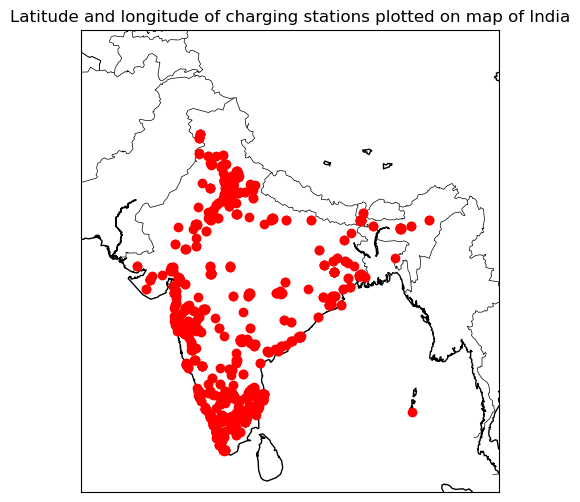

<Figure size 640x480 with 0 Axes>

In [27]:
latitudes = df['latitude']
longitudes = df['longitude']


plt.figure(figsize=(10, 6))
map = Basemap(projection='merc', llcrnrlat=5, urcrnrlat=40,
              llcrnrlon=65, urcrnrlon=100, resolution='l')


map.drawcoastlines()
map.drawcountries()
map.drawstates()

x, y = map(longitudes, latitudes)


map.scatter(x, y, marker='o', color='red', zorder=5)

plt.title('Latitude and longitude of charging stations plotted on map of India')

plt.show()

plt.savefig('charging_stations_plotted.png')




# 4. Geospatial Analysis

We need to create gdf dataframes such that the lat, long values can be plotted using folium

In [29]:

df['geometry'] = [Point(lon, lat) for lon, lat in zip(df['longitude'], df['latitude'])]

gdf = gpd.GeoDataFrame(df, geometry='geometry')

print(gdf.head())


                                                name  ...                   geometry
0                 Neelkanth Star DC Charging Station  ...  POINT (76.98030 29.60190)
1                       Galleria DC Charging Station  ...  POINT (77.08180 28.46730)
2  Highway Xpress (Jaipur-Delhi) DC charging station  ...  POINT (76.27600 27.87510)
3                  Food Carnival DC Charging Station  ...  POINT (77.72180 29.31050)
4                  Food Carnival AC Charging Station  ...  POINT (77.72180 29.31050)

[5 rows x 8 columns]


In [30]:
gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1539 entries, 0 to 1538
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   name       1539 non-null   object  
 1   state      1539 non-null   object  
 2   city       1539 non-null   object  
 3   address    1499 non-null   object  
 4   latitude   1539 non-null   float64 
 5   longitude  1539 non-null   float64 
 6   type       1531 non-null   float64 
 7   geometry   1539 non-null   geometry
dtypes: float64(3), geometry(1), object(4)
memory usage: 96.3+ KB


In [31]:
gdf

,name,state,city,address,latitude,longitude,type,geometry
0,Neelkanth Star DC Charging Station,Haryana,Gurugram,"Neelkanth Star Karnal, NH 44, Gharunda, Kutail...",29.601900,76.980300,12.0,POINT (76.98030 29.60190)
1,Galleria DC Charging Station,Haryana,Gurugram,"DLF Phase IV, Sector 28, Gurugram, Haryana 122022",28.467300,77.081800,12.0,POINT (77.08180 28.46730)
2,Highway Xpress (Jaipur-Delhi) DC charging station,Rajasthan,Behror,"Jaipur to Delhi Road, Behror Midway, Behror, R...",27.875100,76.276000,12.0,POINT (76.27600 27.87510)
3,Food Carnival DC Charging Station,Uttar Pradesh,Khatauli,"Fun and Food Carnival, NH 58, Khatauli Bypass,...",29.310500,77.721800,12.0,POINT (77.72180 29.31050)
4,Food Carnival AC Charging Station,Uttar Pradesh,Khatauli,"NH 58, Khatauli Bypass, Bhainsi, Uttar Pradesh...",29.310500,77.721800,12.0,POINT (77.72180 29.31050)
...,...,...,...,...,...,...,...,...
1534,Tata Power,Kerala,Munnar,"Gokulam Park Munnar, Power House Road, South C...",10.029793,77.045859,7.0,POINT (77.04586 10.02979)
1535,Tata Power,Haryana,Gurgaon,"Vatika Town Square II, Sector 82, Sector 82, V...",28.390459,76.959200,7.0,POINT (76.95920 28.39046)
1536,Tata Power,Haryana,Gurgaon,"Zedex TATA, Sec 48, GF-26, NIHO Scottish Mall,...",28.411072,77.040546,7.0,POINT (77.04055 28.41107)
1537,Tata Power,Jammu,Jammu,"Le ROI, Jammu, Railway Station, Jammu, Jammu &...",32.706412,74.879203,7.0,POINT (74.87920 32.70641)


In [34]:

map = folium.Map(location=[15, 30], tiles="Cartodb dark_matter", zoom_start=2)

heat_data = [[point.xy[1][0], point.xy[0][0]] for point in gdf.geometry]

heat_map = plugins.HeatMap(heat_data)

heat_map.add_to(map)

map.save("heatmap.html")

In [36]:
map

This heatmap data can be used at the time of evaluation and demonstration. We can select areas where there aren't a lot of stations and see if the pricing in those areas is high. We can also select areas with high frequency of stations and see low pricing

To find the number of stations around a particular station using longitude and latitude data and base maps, we utilize the concept of proximity. By specifying a radius, typically in kilometers, we can determine how many stations are within that radius of the target station. .

In our case, the decision to use a 70-kilometer radius is made based on current understanding and practical considerations of electric vehicle (EV) behavior. Here's the reasoning behind it:

1. **Battery Level Consideration**: EVs often begin alerting drivers to find charging stations when their battery level drops to around 20-30%. For instance, the MG ZS EV is known to prompt drivers at this threshold.

2. **Range of EVs**: Electric cars typically have a range, commonly around 350 kilometers on a full charge. This figure can vary depending on the model and other factors.

3. **Calculation**: If we take 20% of the 350-kilometer range, we get 70 kilometers. This means that when an EV reaches around 20% battery capacity, it has approximately 70 kilometers of range remaining.

However, it's essential to note that this value is not set in stone and may be subject to change as the project develops and more data becomes available. Adjustments to the radius may be necessary to better align with real-world scenarios and user needs.

In [38]:
def num_stations_around(latitude, longitude, data):
    """
    Calculates the number of stations around a particular latitude and longitude within a 10 km radius.
    
    Parameters:
    - latitude (float): Latitude of the location.
    - longitude (float): Longitude of the location.
    - data (DataFrame): DataFrame containing latitude and longitude of stations.
    
    Returns:
    - num_stations (int): Number of stations around the given latitude and longitude within a 70 km radius.
    """
    num_stations = 0
    for index, row in data.iterrows():
        distance = geodesic((latitude, longitude), (row['latitude'], row['longitude'])).kilometers
        if distance <= 70:
            num_stations += 1
    return num_stations

In [40]:
num_stations = []
for index, row in df.iterrows():
    print(index, "/1538")
    num_stations.append(num_stations_around(row['latitude'], row['longitude'], df))

0 /1538
1 /1538
2 /1538
3 /1538
4 /1538
5 /1538
6 /1538
7 /1538
8 /1538
9 /1538
10 /1538
11 /1538
12 /1538
13 /1538
14 /1538
15 /1538
16 /1538
17 /1538
18 /1538
19 /1538
20 /1538
21 /1538
22 /1538
23 /1538
24 /1538
25 /1538
26 /1538
27 /1538
28 /1538
29 /1538
30 /1538
31 /1538
32 /1538
33 /1538
34 /1538
35 /1538
36 /1538
37 /1538
38 /1538
39 /1538
40 /1538
41 /1538
42 /1538
43 /1538
44 /1538
45 /1538
46 /1538
47 /1538
48 /1538
49 /1538
50 /1538
51 /1538
52 /1538
53 /1538
54 /1538
55 /1538
56 /1538
57 /1538
58 /1538
59 /1538
60 /1538
61 /1538
62 /1538
63 /1538
64 /1538
65 /1538
66 /1538
67 /1538
68 /1538
69 /1538
70 /1538
71 /1538
72 /1538
73 /1538
74 /1538
75 /1538
76 /1538
77 /1538
78 /1538
79 /1538
80 /1538
81 /1538
82 /1538
83 /1538
84 /1538
85 /1538
86 /1538
87 /1538
88 /1538
89 /1538
90 /1538
91 /1538
92 /1538
93 /1538
94 /1538
95 /1538
96 /1538
97 /1538
98 /1538
99 /1538
100 /1538
101 /1538
102 /1538
103 /1538
104 /1538
105 /1538
106 /1538
107 /1538
108 /1538
109 /1538
110 /1538


In [41]:
np.unique(np.array(num_stations))

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  45,  46,  47,  49,  53,  54,  55,  57,  59,  60,
        61,  62,  63,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        84,  86,  88,  89,  90,  91,  93,  94,  95,  98, 107, 109, 111,
       113, 114, 115, 116, 117, 118, 119, 120, 123, 133, 134, 140, 184,
       186, 206, 228, 253, 254, 255, 256, 257, 259])

In [42]:
len_unique_num_stations = len(np.unique(np.array(num_stations)))

In [43]:
len_unique_num_stations

100

In [44]:
100/7

14.285714285714286

In [45]:
chunk_size = 15
chunks = [(np.unique(np.array(num_stations)))[i:i+chunk_size] for i in range(0, len((np.unique(np.array(num_stations)))), chunk_size)]

range = []
for item in chunks:
    range.append([min(item), max(item)])

In [46]:
range

[[1, 15], [16, 30], [31, 47], [49, 69], [70, 98], [107, 140], [184, 259]]

In [47]:
df['stations around'] = num_stations

In [48]:
df

,name,state,city,address,latitude,longitude,type,geometry,stations around
0,Neelkanth Star DC Charging Station,Haryana,Gurugram,"Neelkanth Star Karnal, NH 44, Gharunda, Kutail...",29.601900,76.980300,12.0,POINT (76.9803 29.6019),9
1,Galleria DC Charging Station,Haryana,Gurugram,"DLF Phase IV, Sector 28, Gurugram, Haryana 122022",28.467300,77.081800,12.0,POINT (77.0818 28.4673),253
2,Highway Xpress (Jaipur-Delhi) DC charging station,Rajasthan,Behror,"Jaipur to Delhi Road, Behror Midway, Behror, R...",27.875100,76.276000,12.0,POINT (76.276 27.8751),10
3,Food Carnival DC Charging Station,Uttar Pradesh,Khatauli,"Fun and Food Carnival, NH 58, Khatauli Bypass,...",29.310500,77.721800,12.0,POINT (77.7218 29.3105),14
4,Food Carnival AC Charging Station,Uttar Pradesh,Khatauli,"NH 58, Khatauli Bypass, Bhainsi, Uttar Pradesh...",29.310500,77.721800,12.0,POINT (77.7218 29.3105),14
...,...,...,...,...,...,...,...,...,...
1534,Tata Power,Kerala,Munnar,"Gokulam Park Munnar, Power House Road, South C...",10.029793,77.045859,7.0,POINT (77.0458592 10.0297934),9
1535,Tata Power,Haryana,Gurgaon,"Vatika Town Square II, Sector 82, Sector 82, V...",28.390459,76.959200,7.0,POINT (76.9592003 28.3904593),255
1536,Tata Power,Haryana,Gurgaon,"Zedex TATA, Sec 48, GF-26, NIHO Scottish Mall,...",28.411072,77.040546,7.0,POINT (77.040546 28.411072),253
1537,Tata Power,Jammu,Jammu,"Le ROI, Jammu, Railway Station, Jammu, Jammu &...",32.706412,74.879203,7.0,POINT (74.8792033 32.7064117),7


In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1539 entries, 0 to 1538
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             1539 non-null   object 
 1   state            1539 non-null   object 
 2   city             1539 non-null   object 
 3   address          1499 non-null   object 
 4   latitude         1539 non-null   float64
 5   longitude        1539 non-null   float64
 6   type             1531 non-null   float64
 7   geometry         1539 non-null   object 
 8   stations around  1539 non-null   int64  
dtypes: float64(3), int64(1), object(5)
memory usage: 108.3+ KB


Now that we have calculate the number of stations around a 70km radius of a particular station, we can calulate the price for that station. Here is the pricing scheme that we are using.



RANGE -----------> PRICE (/kwh)
1. [1, 15]   -->  Rs. 9
2. [16, 30]  -->  Rs. 8
3. [31, 47]  -->  Rs. 7
4. [49, 69]  -->  Rs. 6
5. [70, 98]  -->  Rs. 5
6. [107, 140]  -->  Rs. 4
7. [184, 259]  -->  Rs. 3



The pricing has been decided on data from the following website:



NOTE: THIS IS SUBJECT TO CHANGE AS THE PRODUCT DEVELOPS AND GROWS: https://www.shriramgi.com/article/cost-of-charging-electric-car-in-india#:~:text=For%20instance%2C%20Electric%20Car%20Charging,to%20Rs%209%20per%20unit.

In [50]:

price_list = []

for index, row in df.iterrows():
    stations_around = row['stations around']
    for range_index, range_values in enumerate(range):
        if range_values[0] <= stations_around <= range_values[1]:
            price_list.append(9 - range_index)
            break  

df['price'] = price_list

In [51]:
min(price_list)

3

In [52]:
max(price_list)

9

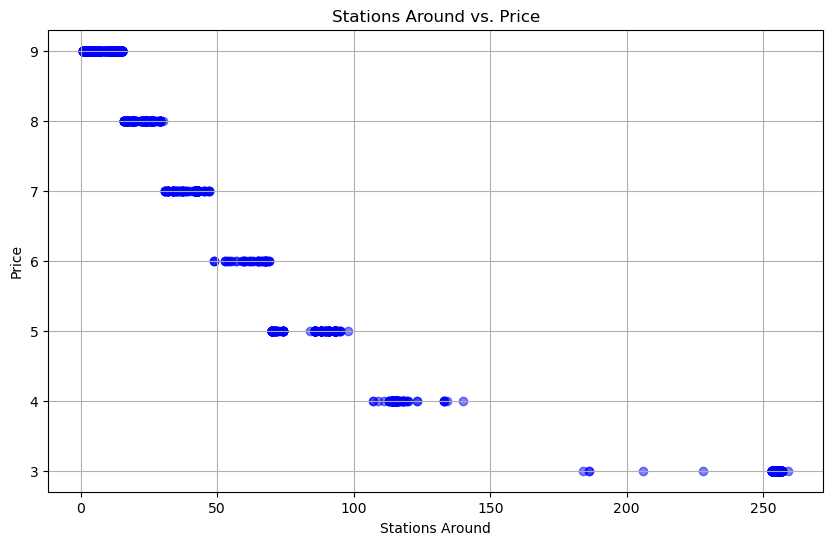

<Figure size 640x480 with 0 Axes>

In [53]:

plt.figure(figsize=(10, 6))
plt.scatter(df['stations around'], price_list, color='blue', alpha=0.5)
plt.xlabel('Stations Around')
plt.ylabel('Price')
plt.title('Stations Around vs. Price')
plt.grid(True)
plt.show()

plt.savefig("stations_around_vs_price.png")

In [57]:
# dataframe additions --> geolocation added, number of stations added, pricing added

df.to_csv('training data/final_df.csv')

## 5.Modelling 

In [58]:
X = df[['latitude', 'longitude']]
y = df['price']

In [59]:
X

,latitude,longitude
0,29.601900,76.980300
1,28.467300,77.081800
2,27.875100,76.276000
3,29.310500,77.721800
4,29.310500,77.721800
...,...,...
1534,10.029793,77.045859
1535,28.390459,76.959200
1536,28.411072,77.040546
1537,32.706412,74.879203


In [60]:
y

0       9
1       3
2       9
3       9
4       9
       ..
1534    9
1535    3
1536    3
1537    9
1538    9
Name: price, Length: 1539, dtype: int64

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [65]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape # shapes are in order

((1231, 2), (1231,), (308, 2), (308,))

##  6. Training and Evaluation

The estimator has been chosen by doing a run through of the sklearn estimator selection map

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

In [66]:
estimator = RandomForestRegressor()

In [67]:
estimator.fit(X_train, y_train)

RandomForestRegressor()

In [68]:
estimator.score(X_train, y_train)

0.9962056418186674

In [69]:
estimator.score(X_test, y_test)b

0.9791775686454649

In [ ]:
es

In [76]:

param_grid = {
    'max_depth': [3, 5, 10, None],
    'n_estimators': [10, 100, 200],
    'max_features': [1, 3, 5, 7],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 3]
}

warnings.filterwarnings('ignore')

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator, param_distributions=param_grid, n_iter=100, cv=5, scoring='accuracy', verbose=3)


random_search.fit(X_train, y_train)


best_params = random_search.best_params_


Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END max_depth=10, max_features=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=nan total time=   0.0s
[CV 2/5] END max_depth=10, max_features=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=nan total time=   0.0s
[CV 3/5] END max_depth=10, max_features=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=nan total time=   0.0s
[CV 4/5] END max_depth=10, max_features=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=nan total time=   0.0s
[CV 5/5] END max_depth=10, max_features=3, min_samples_leaf=1, min_samples_split=2, n_estimators=10;, score=nan total time=   0.0s
[CV 1/5] END max_depth=3, max_features=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=nan total time=   0.1s
[CV 2/5] END max_depth=3, max_features=5, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=nan total time=   0.1s
[CV 3/5] END max_dep

In [77]:
best_params

{'n_estimators': 10,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 3,
 'max_depth': 10}

In [80]:
fin_model = RandomForestRegressor(
    n_estimators=10,
    min_samples_leaf=1,
    min_samples_split=2,
    max_features=3,
    max_depth=10
)

In [81]:
fin_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features=3, n_estimators=10)

In [82]:
fin_model.score(X_test, y_test)

0.9722817681774454

In [85]:
def score_regression_model(model, X, y):
    """
    Score a regression model on various metrics.
    
    Parameters:
        model: The regression model to be scored.
        X: The feature matrix.
        y: The true target values.
        
    Returns:
        A dictionary containing the scores for MAE, MSE, RMSE, and R2.
    """
    y_pred = model.predict(X)
    
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    
    scores = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2
    }
    
    return scores


In [87]:
score_regression_model(fin_model,X_test, y_test) #scores verified and deemed acceptable

{'MAE': 0.13906515197186645,
 'MSE': 0.15011597587969203,
 'RMSE': 0.38744802990813104,
 'R2': 0.9722817681774454}

In [89]:
from joblib import dump

dump(fin_model, 'models/regression_model_3_23_pm_13_apr_2024.joblib')


['models/regression_model_3_23_pm_13_apr_2024.joblib']

In [2]:
from joblib import load

loaded_model = load('models/regression_model_3_23_pm_13_apr_2024.joblib')
predicted_price = loaded_model.predict([[29.60190,76.980300]])
print(predicted_price)

[9.]


/Users/anhadsinghnarang/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [8]:
import gradio as gr
from joblib import load

def predict_price(latitude, longitude):
    loaded_model = load('models/regression_model_3_23_pm_13_apr_2024.joblib')
    predicted_price = loaded_model.predict([[float(latitude), float(longitude)]])
    return round(predicted_price[0])

inputs = [
    gr.inputs.Textbox(label="Latitude"),
    gr.inputs.Textbox(label="Longitude")
]

output = gr.outputs.Textbox(label="Predicted Price")

gr.Interface(fn=predict_price, inputs=inputs, outputs=output, title="House Price Prediction",
             description="Enter latitude and longitude to predict house price.").launch()


/var/folders/tv/pb9fh99534330fzc4_z2rzxc0000gn/T/ipykernel_18703/3789155337.py:10: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  gr.inputs.Textbox(label="Latitude"),
/var/folders/tv/pb9fh99534330fzc4_z2rzxc0000gn/T/ipykernel_18703/3789155337.py:10: GradioDeprecationWarning: `optional` parameter is deprecated, and it has no effect
  gr.inputs.Textbox(label="Latitude"),
/var/folders/tv/pb9fh99534330fzc4_z2rzxc0000gn/T/ipykernel_18703/3789155337.py:10: GradioDeprecationWarning: `numeric` parameter is deprecated, and it has no effect
  gr.inputs.Textbox(label="Latitude"),
/var/folders/tv/pb9fh99534330fzc4_z2rzxc0000gn/T/ipykernel_18703/3789155337.py:11: GradioDeprecationWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  gr.inputs.Textbox(label="Longitude")
/var/folders/tv/pb9fh99534330fzc4

Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.


/Users/anhadsinghnarang/miniconda3/envs/myenv/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


------------------------    END ----------------------------
